In [1]:
import sys; sys.path.insert(0, '..')
from database.dataset import *
import pyforest
%matplotlib inline

In [37]:
def easy_plot(i):
    plt.figure()
    plt.imshow(db[i]['img'], cmap='gray' )
    plt.imshow(db[i]['lesion_mask'])
    plt.axis('off')
    plt.show()

In [18]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        max_lesion_size_mm=1.0,
        extract_rois=True,
        extract_rois_method='all',  # 'centered'
        roi_size=256,
        stride=256,
        min_breast_fraction_roi=0.8,
        normalize=None,
        n_jobs=-1,
)

In [17]:
# db.rois_df.loc[db.rois_df.img_id==22678449]

In [21]:
len(db[1]['lesion_bboxes'])

13

In [27]:
i[0]

(992, 2218)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

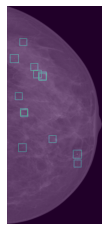

In [36]:
roi_mask = np.zeros(db[1]['img'].shape)
for i in db[1]['lesion_bboxes']:
    roi_mask = cv2.rectangle(roi_mask, (i[0][0]-50, i[0][1]-50), (i[1][0]+50, i[1][1]+50), 255, 3)
plt.figure()
plt.imshow(db[1]['img'], cmap='gray' )
plt.imshow(roi_mask, alpha=0.5)
plt.axis('off')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

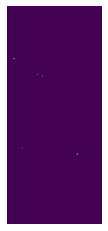

In [38]:
easy_plot(1)

In [39]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='rois',
        max_lesion_size_mm=1.0,
        extract_rois=True,
        extract_rois_method='all',  # 'centered'
        roi_size=256,
        stride=256,
        min_breast_fraction_roi=0.8,
        normalize=None,
        n_jobs=-1,
)

100%|██████████| 310/310 [00:30<00:00, 10.10it/s]


In [40]:
# db.df.loc[db.df.img_id==22614499]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

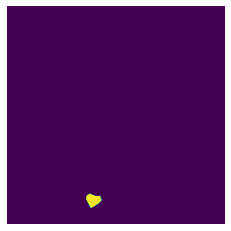

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

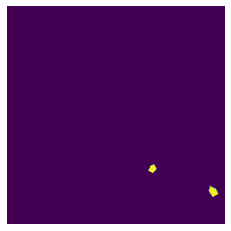

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

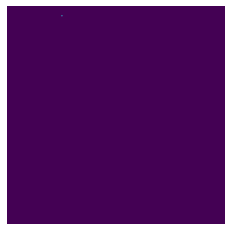

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

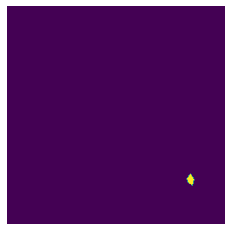

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

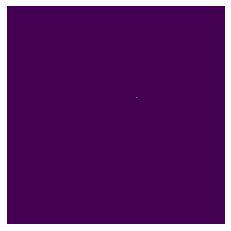

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

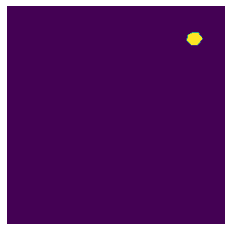

In [41]:
for i in range(56,98):
    if db[i]['lab'] == 'abnormal':
        easy_plot(i)

In [42]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='rois',
        max_lesion_size_mm=1.0,
        extract_rois=False,
        extract_rois_method='all',  # 'centered'
        roi_size=256,
        stride=256,
        min_breast_fraction_roi=0.8,
        normalize=None,
        n_jobs=-1,
)